In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import hvplot.xarray
import hvplot
import cmocean

import matplotlib as mpl

hvplot.output(widget_location='bottom')

from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from helpers.plot_helpers import *
from helpers.selectors import *

import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 3

In [6]:
ZBu = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1})
ZBv = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1})
ZBT = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.tos.nc', chunks={'time':1})

In [3]:
loresu = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1})
loresv = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1})

In [7]:
def KE(u,v,T):
    return 0.5*(remesh(u**2, T) + remesh(v**2,T))

In [8]:
ZBke = KE(ZBu.ssu, ZBv.ssv, ZBT.tos)
loreske = KE(loresu.ssu, loresv.ssv, ZBT.tos)

In [9]:
ann = xr.open_mfdataset('/scratch/pp2681/mom6/global_simulations/OM4_025.JRA/output/ocean_daily*', chunks={'time':1})

In [10]:
annke = KE(ann.ssu, ann.ssv, ZBT.tos)

# Geostrophic velocities from data

In [94]:
from xgcm import Grid
def geostrophic_velocity(ds, ssh):
    '''
    ds contains coordinate information (xh, yh, xq, yq)
    ssh is an array in xh, yh points
    '''
    res = ds.xh[1] - ds.xh[0]
    grid = Grid(ds.drop_vars('time'), coords={
            'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
            },
            periodic = 'X'
            )
    
    R = 6.371e+6 # Earth radius in metres|
    deg_to_rad = np.pi / 180 # degrees to radians factor
    dx = res * R * deg_to_rad * np.cos(ds.yh * deg_to_rad)
    dy = res * R * deg_to_rad
    g = 9.8
    Omega = 7.2921e-5
    fh = 2 * Omega * np.sin(ds.yh * deg_to_rad)
    fq = 2 * Omega * np.sin(ds.yq * deg_to_rad)
    
    # Gradient of the SSH
    hx = grid.diff(ssh, 'X') / dx
    hy = grid.diff(ssh, 'Y') / dy
    
    u = grid.interp(- g / fq * hy, 'Y')
    v = grid.interp(+ g / fh * hx, 'X')
    return u, v

In [95]:
obs = xr.open_dataset('/vast/pp2681/altimetry_Copernicus.nc', chunks={'time':1}).rename({'longitude': 'xh', 'latitude': 'yh'})
res = 0.25
xq = np.array(obs['xh'] + res / 2)
obs['xq'] = xr.DataArray(xq, dims='xq', coords={'xq': xq})

yq = np.array(obs['yh'] + res / 2)
obs['yq'] = xr.DataArray(yq, dims='yq', coords={'yq': yq})
ug, vg = geostrophic_velocity(obs, obs.adt)

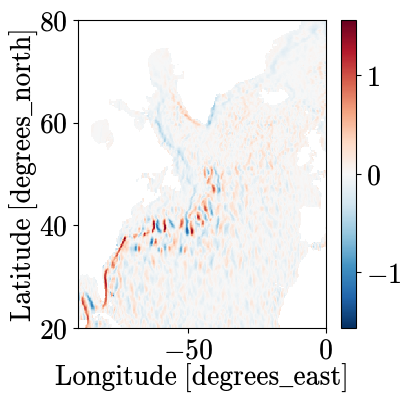

In [96]:
vg.sel(xh=slice(-90,0), yh=slice(20,80)).isel(time=-1).plot()

In [97]:
obskeg = (ug**2 + vg**2) * 0.5

# Plotting velocities

## Selecting 2008 year for most 

In [98]:
ZBu.time[0:2]

<xarray.DataArray 'time' (time: 2)>
array([cftime.DatetimeJulian(2008, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2008, 1, 2, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2008-01-01 12:00:00 2008-01-02 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  JULIAN
    bounds:         time_bnds
    cell_methods:   time: mean

In [99]:
obs.isel(time=slice(5478,None)).time[0:2]

<xarray.DataArray 'time' (time: 2)>
array(['2008-01-01T00:00:00.000000000', '2008-01-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-01-02
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

In [100]:
ann.time[0:2]

<xarray.DataArray 'time' (time: 2)>
array([cftime.DatetimeJulian(1, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1, 1, 2, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 0001-01-01 12:00:00 0001-01-02 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   JULIAN
    bounds:          time_bnds

In [101]:
OBS_vg = np.sqrt(2*obskeg.isel(time=slice(5478,None)))
ZB_v = np.sqrt(2*ZBke)
LORES_v = np.sqrt(2*loreske)
ann_v = np.sqrt(2*annke)

In [109]:
xh = OBS_vg['xh']
xh = xr.where(xh>60, xh-360,xh)
OBS_vg['xh'] = xh
OBS_vg = OBS_vg.sortby('xh')

In [110]:
default_rcParams({'figure.subplot.wspace': 0.1, 'font.size': 20})
def plot_regions(idx=0, lat=slice(20,70), lon=slice(-90,0)):
    fig, axes = plt.subplots(2,2, figsize=(8,8), 
    subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
    
    time_idx=idx
    time_str = LORES_v.time.isel(time=time_idx).item().strftime('%Y-%m-%d')
    time_str_simple = ann_v.time.isel(time=time_idx).item().strftime('%m-%d')
    
    # My preset; Equivalent to plotting surface KE
    cmap = plt.get_cmap('inferno')
    norm = mpl.colors.LogNorm(vmin=0.05, vmax=1.5)
    cmap.set_bad('gray')
    
    ax = axes[0][0]
    ax.coastlines()
    ax.gridlines()
    im = LORES_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('OM4, $1/4^o$', fontsize=20)

    ax = axes[0][1]
    ax.coastlines()
    ax.gridlines()
    im = ZB_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ZB20, $1/4^o$', fontsize=20)

    ax = axes[1][0]
    ax.coastlines()
    ax.gridlines()
    im = ann_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ANN+FCT, $1/4^o$', fontsize=20)

    
    ax = axes[1][1]
    ax.coastlines()
    ax.gridlines()
    im = OBS_vg.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('Observations \n(geostrophic)', fontsize=20)


    cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=100, shrink=1.0, orientation='horizontal')
    cb.set_label(label='Surface velocity, $\mathrm{m}/\mathrm{s}$')
    plt.suptitle(time_str_simple, y=0.95)

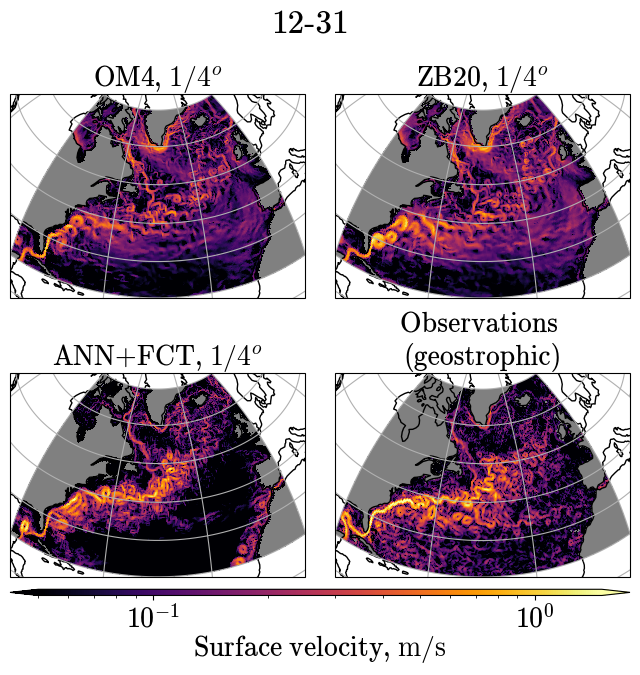

In [111]:
plot_Atlantic = lambda idx: plot_regions(idx=idx)
plot_Atlantic(364)

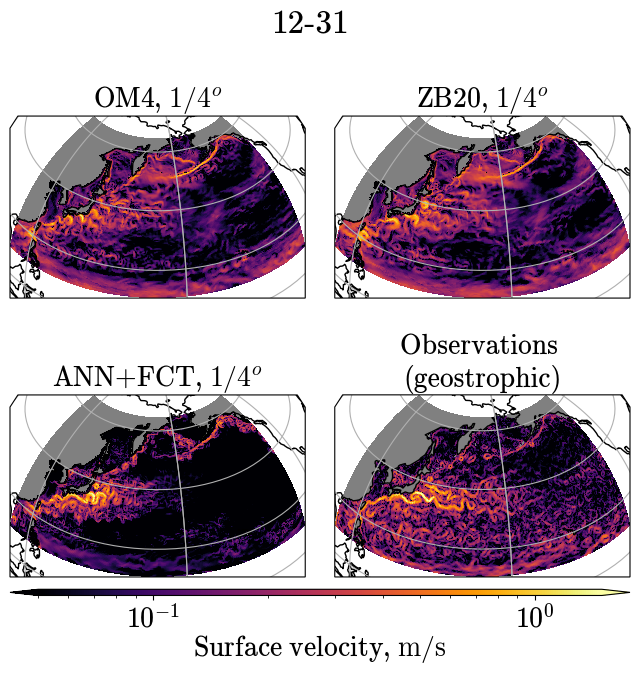

In [112]:
plot_Pacific = lambda idx: plot_regions(idx=idx, lat=slice(10,65), lon=slice(-250,-130))
plot_Pacific(364)

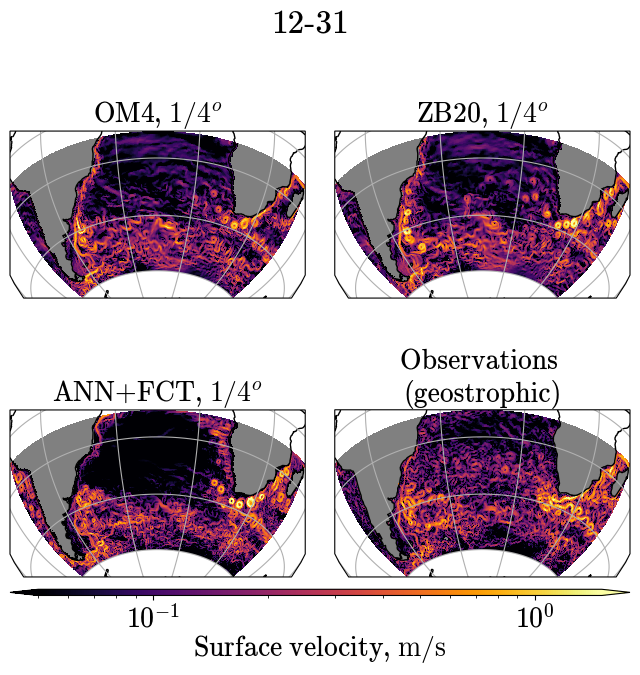

In [116]:
plot_rings = lambda idx: plot_regions(idx=idx, lat=slice(-60,-10), lon=slice(-80,50))
plot_rings(364)

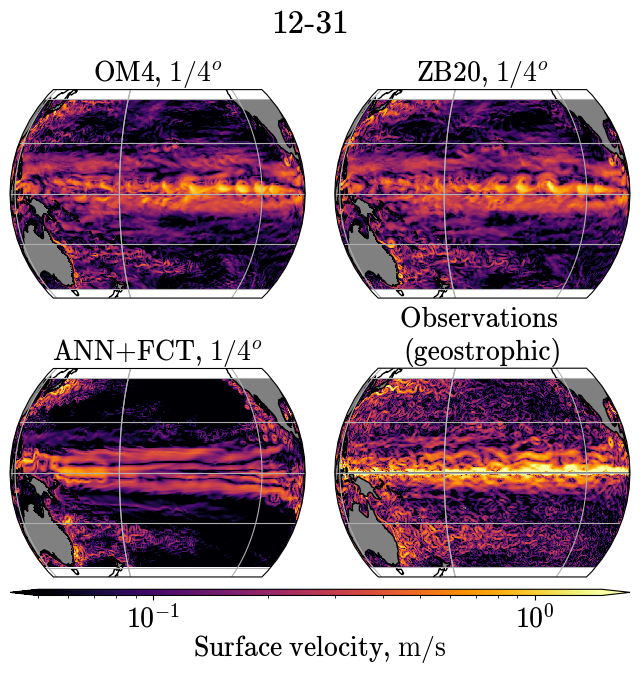

In [126]:
plot_equator = lambda idx: plot_regions(idx=idx, lat=slice(-40,40), lon=slice(-280,-50))
plot_equator(364)

In [127]:
%%time
create_animation_ffmpeg(plot_equator, range(0,365,3), 'ANN_equator.mp4', dpi=200, FPS=20)

Native resolution of snapshots is used: 1280x1342

Animation ANN_equator.mp4 at FPS=20 will last for 6.1 seconds. The frames are saved to 
.ffmpeg/ANN_equator

Running the command:
cd /scratch/pp2681/MOM6-examples/src/MOM6/experiments/ANN-Results/offline_analysis; ffmpeg -y -framerate 20 -i .ffmpeg/ANN_equator/frame-%d.png -s:v 1280x1342 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ANN_equator.mp4


sh: 1: module: not found
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

CPU times: user 8min 15s, sys: 3min 16s, total: 11min 31s
Wall time: 7min 56s


frame=  122 fps= 50 q=-1.0 Lsize=   11054kB time=00:00:05.95 bitrate=15218.6kbits/s speed=2.42x    
video:11051kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.021225%
[libx264 @ 0x55e2c21ee700] frame I:1     Avg QP:20.47  size:219506
[libx264 @ 0x55e2c21ee700] frame P:31    Avg QP:23.06  size:154530
[libx264 @ 0x55e2c21ee700] frame B:90    Avg QP:27.79  size: 70066
[libx264 @ 0x55e2c21ee700] consecutive B-frames:  1.6%  0.0%  0.0% 98.4%
[libx264 @ 0x55e2c21ee700] mb I  I16..4: 13.7% 55.6% 30.7%
[libx264 @ 0x55e2c21ee700] mb P  I16..4:  0.4%  9.6%  4.7%  P16..4:  8.2% 11.2% 13.0%  0.0%  0.0%    skip:53.0%
[libx264 @ 0x55e2c21ee700] mb B  I16..4:  0.1%  3.7%  1.7%  B16..8:  9.6%  8.3%  7.6%  direct: 8.2%  skip:60.9%  L0:34.9% L1:30.7% BI:34.4%
[libx264 @ 0x55e2c21ee700] 8x8 transform intra:65.1% inter:58.5%
[libx264 @ 0x55e2c21ee700] coded y,uvDC,uvAC intra: 87.6% 89.9% 89.3% inter: 27.4% 28.9% 25.3%
[libx264 @ 0x55e2c21ee700] i16 v,h,dc,p: 24% 68%  7%  